In [35]:
import sys
sys.path.append('../modules')

from datacube import read_data
from operators import *
from mask import *
from preprocessing import *
from eof import *
from interpolator import *
from gridding import *
from mapper import *

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


%load_ext autoreload
%autoreload 2
%page
%alias_magic t timeit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


(1257,)

In [2]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'#tas/hdd_CanRCM4-LE_ens35_1951-2016_ann_ta.nc'#jan1.0p/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
iens = interp_dict['iens'][:, master_idx]

In [3]:
u, s, vT = np.linalg.svd(iens, full_matrices=False)

In [76]:
df = pd.read_csv('/storage/data/projects/nrc/station_data/snow_load/swe_rl50_stations_test.csv', index_col=None)
ndf = match_coords(df, interp_dict, 'snow_load_rl50')
obs_idx = ndf['matched_idx']#generate_pseudo_obs(iens, 0.0003)
ndf.head()

,snow_load_rl50,lat,lon,obs_coords,matched_idx
nearest_grid,,,,,
76922,0.954855,42.2756,-82.9556,"(-4.286848910227873, 10.373390404111557)",76922
79138,1.246116,42.3333,-82.9333,"(-4.227125340313413, 10.379271031382924)",79138
80695,1.279574,42.8833,-80.2333,"(-3.2976268496041468, 12.223659162002475)",80695
83623,1.802606,43.0331,-81.1511,"(-3.290371679059054, 11.534368202439223)",83623
91428,6.229182,43.1717,-79.9342,"(-2.9689855230488806, 12.37546741076384)",91428


In [77]:
obs = ndf['snow_load_rl50'].values#iens[8, obs_idx]
eofs = vT[:, obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (35, 525) 
Matched Obs shape:  (525,)


In [78]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

Regressed model score: [0.30205146]


slope 0.3020514630923551


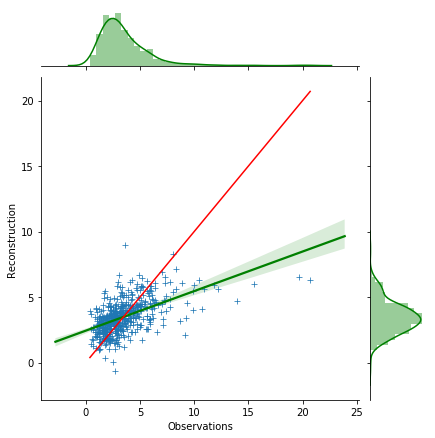

In [79]:
ax = sns.jointplot(obs.T, predictions.T, kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, 
                predictions.T, 
                palette="viridis",
                marker='+'
)
sns.lineplot(obs.T, 
          obs.T,
          color='r')

plt.xlabel('Observations')
plt.ylabel('Reconstruction')
plt.savefig('../plots/snow')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)

print("slope", slope)

In [82]:
# weighting!

X = df[['lat', 'lon']].values

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=int(X.shape[0]/5.0), random_state=0).fit(X)

In [91]:
df['labels'] = kmeans.labels_

In [104]:
df.loc(df['labels'] == df['labels'].value_counts())

ValueError: Can only compare identically-labeled Series objects

In [99]:
kmeans.labels_.shape

(526,)